# Risk Management

In [1]:
import sys
import json
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from tabulate import tabulate
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
import math
import plotly.express as px
import warnings
import general_functio_rm_citi as general_functio_rm
import plotly.figure_factory as ff

warnings.filterwarnings("ignore")


class Risk_Management():
    
    def __init__(self, df: pd.DataFrame, filters_dict: dict = {}, alt_df: pd.DataFrame = None) -> None:
        self.df = df
        self.alt_df = alt_df
        self.filters_dict = filters_dict
        self.df = self._clean_df()
        self.df = self._dataframe_filter()

        # please update it if you want, you can download these data from yahoo finance or investing.com
        self.vix = self._alternatvie_data_clean( pd.read_csv(f"vix.csv", index_col = 0) )
        self.spx = self._alternatvie_data_clean( pd.read_csv(f"spx.csv", index_col = 0) )
     

    def _clean_df(self, df = None) -> None:
        if not isinstance(df, pd.DataFrame) : df = self.df.copy()
        df.d0_date = pd.to_datetime(df.d0_date).dt.date
        df.dropna(subset=["d0_open", "d0_close", "atr", "prev1_close", 'volume_d_10_sma'], inplace=True)
        df.sort_values(by = 'd0_date', inplace = True)
        df['rm_uid'] =  df['ticker'] + df['d0_date'].astype(str) + df['headline']
        df['year'] = df.d0_date.apply(lambda x: x.year)
        df['month']  = df.d0_date.apply(lambda x: x.month)
        r_cols = [i for i in df.columns if ('_r' in i) and ('ex' not in i) and (i.index('_r') == 2)and ( len(i) < 5)]
        df[r_cols] = df[r_cols].astype(float)

        # for gap and limit price analysis
        df["gap_in_atr"] = df.apply(lambda x: self._gap_calculation(x.d0_open, x.prev1_close, x.atr) , axis = 1)
        df["change_from_open"] = df.apply(lambda x: self._gap_up_or_down( x.d0_open, x.d0_close), axis = 1) 
        df["Close (ATRx)"] = df.apply(lambda x:  (x["d0_close"] - x["d0_open"])/x["atr"], axis = 1)
        df["High (ATRx)"] = df.apply(lambda x:  (x["d0_high"] - x["d0_open"])/x["atr"], axis = 1)
        df["Low (ATRx)"] = df.apply(lambda x:  (x["d0_low"] - x["d0_open"])/x["atr"], axis = 1)
        df["gap_intervals"] = df.apply(lambda x: self._gap_interval_classifying(x["gap_in_atr"]), axis = 1)
        return df


    def _alternatvie_data_clean(self, df) -> pd.DataFrame:
        df.index = pd.to_datetime(pd.Series(df.index), format = "%d/%m/%Y").dt.date
        try: df['atr'] = self._atr_calculation(df)
        except: print('Cannot calculate the alt data atr')
        # shift one day for confirming it is not the future data
        return df.shift()


    def _gap_calculation(self, d0_open, prev1_close, atr) -> float:
        if math.isnan(prev1_close): return np.nan
        if math.isnan(atr) or (atr < 0.00001): return np.nan
        gap = (d0_open - prev1_close)
        gap_in_atr = gap/atr
        return gap_in_atr


    def _gap_up_or_down(self, open_price, close_price) -> float:
        if close_price > open_price: return "Up"
        elif close_price < open_price: return "Down"
        else: return "No change"


    def _gap_interval_classifying(self, gap_in_atr) -> str:
        if abs(gap_in_atr) < 0.5: return "<0.5 ATR"
        elif ( 0.5 <= abs(gap_in_atr) ) and (abs(gap_in_atr) < 1 ): return "0.5-1 ATR"
        elif ( 1 <= abs(gap_in_atr) ) and (abs(gap_in_atr) < 2 ): return "1-2 ATR"
        elif ( 2 <= abs(gap_in_atr) ) and (abs(gap_in_atr) < 3 ): return "2-3 ATR"
        elif ( 3 <= abs(gap_in_atr) ) and (abs(gap_in_atr) < 4 ): return "3-4 ATR"
        elif ( 4 <= abs(gap_in_atr) ) and (abs(gap_in_atr) < 5 ): return "4-5 ATR"
        elif abs(gap_in_atr) >= 5: return ">5 ATR"


    def _atr_calculation(self, df, timeperiod=10) -> pd.Series:
        high_low = df['high'] - df['low']
        high_close = np.abs(df['high'] - df['last_price'].shift())
        low_close = np.abs(df['low'] - df['last_price'].shift())
        ranges = pd.concat([high_low, high_close, low_close], axis=1)
        true_range = np.max(ranges, axis=1)
        atr = round((true_range.rolling(timeperiod).sum() / timeperiod), 5)
        return atr


    def _dataframe_filter(self, df = None) -> None:
        """This is a function for filtering the df

        """                  
        if not isinstance(df, pd.DataFrame) : df = self.df
        for var in self.filters_dict.keys():
            if isinstance(self.filters_dict[var], str) or isinstance(self.filters_dict[var], int): self.filters_dict[var] = [self.filters_dict[var]]
            df = df.loc[df[var].isin(self.filters_dict[var])]
        return df


    def _add_r_with_sl(self, df, days=10, entry="d0_open", atrx=1, only_d0 = False, stop_loss_level = 1)  -> pd.DataFrame:
        """
            This function calculates and adds 'r' columns (with stop-loss).
            
            - days: number of Rs to calculate (days=3 means calculate R for day 1,2,3)
            
            - entry: column name for entry price ('d0_open' means trades are enter on day-0, 'entry_price' means the entry price is given)
            
            - atrx: ATR(x) for calculating Rs
            """
        df = df.copy()

        df = df[df["side"].isin(["long", "short"])]

        df["entry_price"] = df[entry]
        df["atrx"] = atrx
        df["atr_used"] = df["atr"] * df["atrx"]

        entry_price = df["entry_price"]
        atr_used = df["atr_used"]
        side = df["side"]

        stopped_or_no_data = False
        exit_price_at_stop = None

        for n in range(days + 1):

            day_n_open = df[f"d{n}_open"]
            day_n_high = df[f"d{n}_high"]
            day_n_low = df[f"d{n}_low"]
            day_n_close = df[f"d{n}_close"]

            # if the security was delisted or expired, day-n data will be missing
            # assume close at the previous day, if this case happens
            try:
                day_n_minus_1_close = df[f"d{n-1}_close"]
            except:
                day_n_minus_1_close = np.nan

            # calculate r from day-n open to entry price
            # check whether the trade will stop at open (because of gap up/down)
            # round to 8 decimal point to avoid floating point error
            r_day_n_open_for_long = round((day_n_open - entry_price) / atr_used, 8)
            stopped_at_day_n_open = ((r_day_n_open_for_long <= -stop_loss_level) & (side == "long")) | (
                (-r_day_n_open_for_long <= -stop_loss_level) & (side == "short")
            )

            # calculate r from day-n high/low to entry price
            # check whether the trade stopped in the day
            # round to 8 decimal point to avoid floating point error
            r_day_n_high_for_long = round((day_n_high - entry_price) / atr_used, 8)
            r_day_n_low_for_long = round((day_n_low - entry_price) / atr_used, 8)
            stopped_at_day_n_middle = ((r_day_n_low_for_long <= -stop_loss_level) & (side == "long")) | (
                (-r_day_n_high_for_long <= -stop_loss_level) & (side == "short")
            )

            conditions = [
                stopped_or_no_data,  # stopped before day-n
                day_n_open.isnull(),  # no data for day-n (eg. de-list / contract expire)
                stopped_at_day_n_open,  # stopped at day-n Open
                stopped_at_day_n_middle,  # stopped at day-n Middle
            ]

            # exit price for the above conditions
            corrresponding_exit_price_day_n = [
                exit_price_at_stop,
                day_n_minus_1_close,
                day_n_open,
                np.where(side == "long", entry_price - atr_used*stop_loss_level, entry_price + atr_used*stop_loss_level),
            ]

            # exit price for day-n
            exit_price_day_n = np.select(
                conditions, corrresponding_exit_price_day_n, default=day_n_close
            )

            # calculate day-n R
            r_exit_for_long = (exit_price_day_n - entry_price) / atr_used
            df[f"d{n}_r"] = np.where(side == "long", r_exit_for_long, -r_exit_for_long)

            # update status(stopped or not) and exit price(if stopped)
            stopped_or_no_data = (
                stopped_or_no_data
                | day_n_open.isnull()
                | stopped_at_day_n_open
                | stopped_at_day_n_middle
            )
            exit_price_at_stop = np.where(stopped_or_no_data, exit_price_day_n, np.nan)
        if only_d0: return df[['d0_r']]
        else: return df
    

    def _drawdown_statistic(self, df, col) -> tuple:
        """This is a functoin for calculating drawdown


        Args:
            col (string): column name
            df (dataframe): dataset

        Returns:
            drawdown (array)
            mdd_preriod, mdd (folat)
        """          
        
        equity_curve_bydate = df.groupby('d0_date').sum()[col].cumsum()
        self.equity_curve_bydate = equity_curve_bydate
        period_count, period_list_temp = 0, []  
        drawdown = (equity_curve_bydate - equity_curve_bydate.cummax()).values
        for k in range(len(drawdown)):
            if drawdown[k] < -0.0001: period_count +=  1
            else: period_count = 0
            period_list_temp.append(period_count)
        mdd_preriod = max(period_list_temp)
        mdd = min(drawdown)
        return drawdown, mdd_preriod, mdd


    def _skewness_calculation(self, params_hd = 2 ) -> None:
        """This is a function for calculating the skewnss

        Args:
            params_hd (int, optional): hodling days, close at d1 -> 2. Defaults to 2.

        Returns:
            series
        """        
        pnl_date = {}
        traded_date = list(sorted((df.d0_date.unique())))
        for i in range(len( traded_date ) ) :
            if i <= params_hd-1: pnl_date[traded_date[i]] = traded_date[:i+1]
            else: pnl_date[traded_date[i]] = traded_date[i-(params_hd-1):i+1]

        date_skewness = {}
        for date in traded_date:
            tdy_pnl_date = pnl_date[date]
            tdy_pnl_skew = 0
            for i in range(-len(tdy_pnl_date), 0):
                count = i
                d_neg_date = tdy_pnl_date[count]
                d_neg_df = self.df.loc[self.df.d0_date == d_neg_date][['side',f'd{-count}_r']] 
                tdy_skew = np.where((d_neg_df.loc[d_neg_df[f'd{-count}_r']> -0.99999]).side == 'long', 1, -1).sum()
                tdy_pnl_skew += tdy_skew
            date_skewness[date] = tdy_pnl_skew

        self.df['skewness'] = self.df.d0_date.map(date_skewness)
    

    def _rolling_atrx_calculation(self, params_lb = 20) -> None:
        """This functoin is for getting optimal atrx by looking back n days and maximising the cash adjusted expectancy

        Args:
            params_lb (int, optional): _description_. Defaults to 20.
        """        

        if 'd0_r_rolling_optimised_atrx' in self.df.columns: 
            print('already calculated the rolling atrx')
            return

        d0_r_for_diff_atrx_setting, date_atrx_dict, date_rolling_list = {}, {}, []
        performance_with_optimal_atrx = pd.DataFrame()
        params_atrx_range = np.arange(0.7, 2, 0.1)

        for date, data_grp in self.df.groupby('d0_date'):
            if len(date_rolling_list)> params_lb:
                max_exp, optimal_atrx = -np.inf, 1
                d0_r_for_diff_atrx_setting[date] = {}
                for param_atrx in params_atrx_range:
                        param_atrx = round(param_atrx, 5)
                        d0_r_for_diff_atrx_setting[date][param_atrx] = self._add_r_with_sl(self.df.loc[self.df.d0_date.isin(date_rolling_list[-params_lb:])], \
                            atrx = param_atrx, only_d0 = True)
                        if d0_r_for_diff_atrx_setting[date][param_atrx].d0_r.mean()*param_atrx > max_exp:
                            max_exp = d0_r_for_diff_atrx_setting[date][param_atrx].d0_r.mean()*param_atrx
                            optimal_atrx = param_atrx
                date_atrx_dict[date] = optimal_atrx
                performance_with_optimal_atrx = pd.concat([performance_with_optimal_atrx, self._add_r_with_sl(data_grp, atrx = optimal_atrx)])
            else: 
                date_atrx_dict[date] = 1
                performance_with_optimal_atrx = pd.concat([performance_with_optimal_atrx, self._add_r_with_sl(data_grp, atrx = 1)])
            date_rolling_list.append(date)
        self.df['rolling_optimal_atrx'] = self.df.d0_date.map(date_atrx_dict)
        self.df['d0_r_rolling_optimised_atrx'] = performance_with_optimal_atrx.d0_r.astype(float)

        df = self.df.copy()

        pnl_df_dict = {'all': df, 'long': df.loc[df.side == 'long'], 'short': df.loc[df.side == 'short']}
        stat_days_dict = {'all': 1, 'long': 1, 'short': 1 } ###
        # columns -> d0 all, d1 all, d2 all, d0 all, d0 long, d1 long, d0 short, d1 short

        columns_list = [('d0', 'all'), ('d0', 'long'), ('d0', 'short'), ('d0', 'all_r.atrx'), ('d0', 'long_r.atrx'), ('d0', 'short_r.atrx')]
        
        stat_name = [ 'total_r', 'expectancy', 'total_trades', 'hit_ratio', 'max_drawdown', 'mdd_period', 'average_holding_days', \
            'average_atrx_used', 'stop_loss_ratio', 'averge_pos_per_day', 'total_r(same cash)', 'expectancy(same cash)']
        stat_dict, stat_dict_rolling, stat_list = {}, {}, []
        for name in stat_name:
            stat_dict[name] = self._basic_stat_calculation(pnl_df_dict, stat_days_dict, name, col = 'r' )
            stat_dict_rolling[name] = self._basic_stat_calculation(pnl_df_dict, stat_days_dict, name, col = 'r_rolling_optimised_atrx', col_atrx = 'rolling_optimal_atrx')
            stat_list.append( sum(list(stat_dict[name].values()), []) + sum(list(stat_dict_rolling[name].values()), []) )
        
        stat_df = pd.DataFrame(stat_list, columns= columns_list, index = stat_name)
        stat_df.columns = pd.MultiIndex.from_tuples(stat_df.columns)
        stat_df = stat_df[sorted(columns_list)]
        self.stat_df = stat_df.copy()
        print('\n' + '*'*30 + ' Rolling ATRx Performance ' + '*'*30 + '\n')
        print(f'Start Date: {df.d0_date.iloc[0]}')
        print(f'End Date: {df.d0_date.iloc[-1]}')
        print(tabulate(stat_df.round(3), headers = ["staistic"] + list(stat_df.columns),  tablefmt = 'fancy_grid') )

        temp = self.df.groupby( [self.df.d0_date.apply(lambda x: x.year).rename('y'), \
            self.df.d0_date.apply(lambda x: x.month).rename('m')]).mean()
        temp.reset_index(inplace = True)
        temp['y_m'] = temp.y.astype(str) + '-' + temp.m.astype(str)
        fig = px.line(temp, x='y_m', y='rolling_optimal_atrx', width=1300, height=500, markers=True, )
        fig.update_layout( title=f'optimal atrx used (monthly mean)')
        fig.show()

        
    def _pnl_visulazation(self, line_mode = 'lines+markers', skip_rolling = True) -> None:

        if skip_rolling == False: 
            if 'd0_r_rolling_optimised_atrx' not in self.df.columns: self._rolling_atrx_calculation()

        df = self.df.copy()

        traded_date = list(df.d0_date.unique())
        df_daily = pd.DataFrame()
        for date, df_grp in df.groupby('d0_date'):
            if traded_date.index(date) == 0: continue
            else:  prev_trading_date_df = df.loc[df.d0_date == traded_date[:traded_date.index(date)][-1] ]
            r_get_from_prevdate = prev_trading_date_df.d1_r.sum()-prev_trading_date_df.d0_r.sum()
            r_get_from_tdy = df_grp.d0_r.sum()
            if skip_rolling == False:
                r_get_from_tdy_optimal_atrx = df_grp.d0_r_rolling_optimised_atrx.sum()
                df_daily = pd.concat([df_daily, pd.DataFrame({'r_from_tdy_trades': r_get_from_tdy, 'r_from_prev_trades': r_get_from_prevdate, \
                    'r_from_tdy_trades_optimal_atrx': r_get_from_tdy_optimal_atrx}, index = [date])])
            else:
                df_daily = pd.concat([df_daily, pd.DataFrame({'r_from_tdy_trades': r_get_from_tdy, 'r_from_prev_trades': r_get_from_prevdate, }, index = [date])])
        df_daily['d0_date'] = df_daily.index
        self.df_daily = df_daily
        drawdown, _, _ = self._drawdown_statistic( df_daily, 'r_from_tdy_trades' )
        if skip_rolling == False: drawdown_optimal_atrx, _, _ = self._drawdown_statistic( df_daily, 'r_from_tdy_trades_optimal_atrx' )


        fig = go.Figure()
        if skip_rolling == False: 
            number_of_plot = 3
            row_width_ = [0.1, 0.15, 0.4]
        else: 
            number_of_plot = 2
            row_width_ = [ 0.15, 0.4]
        fig = make_subplots(rows=number_of_plot, cols=1, shared_xaxes=True, vertical_spacing=0.02 ,specs=[[{"secondary_y": True}]]*number_of_plot, row_width = row_width_ )

        fig.add_trace( go.Scatter( x = df_daily.index, y = df.groupby('d0_date').sum()['d0_r'].loc[df_daily.index].cumsum(), \
            name = 'd0_r_curve', marker_color='steelblue',  mode=line_mode,), row=1, col =1 , secondary_y= False)
        fig.add_trace( go.Scatter( x = df_daily.index, y = df.groupby('d0_date').sum()['d1_r'].loc[df_daily.index].cumsum(), \
            name = 'd1_r_curve', marker_color='gray', mode=line_mode,), row=1, col =1 , secondary_y= False)
        fig.add_trace( go.Scatter( x = df_daily.index, y = df.groupby('d0_date').sum()['d2_r'].loc[df_daily.index].cumsum(), \
            name = 'd2_r_curve', marker_color='blue', mode=line_mode,), row=1, col =1 , secondary_y= False)
        fig.add_trace( go.Scatter( x = df_daily.index, y = df.groupby('d0_date').sum()['d0_r'].loc[df_daily.index].cumsum(), \
            name = 'd0_r_curve', marker_color='orange', mode=line_mode,), row=1, col =1 , secondary_y= False)


        if not isinstance(self.alt_df, pd.core.frame.DataFrame): self.alt_df = self.vix
        fig.add_trace( go.Scatter( x = self.vix.loc[self.vix.index.isin(df_daily.index)].index, y = self.vix.loc[self.vix.index.isin(df_daily.index)].last_price,\
            name = 'vix', line = dict(color='firebrick', width=0.8, dash='dash')), row=1, col =1 , secondary_y= True)

        daily_r_multiple = 1
        fig.add_trace( go.Bar( x = df_daily.index, y = df_daily.r_from_tdy_trades*daily_r_multiple, marker_color='steelblue' , name = 'r from tdy'), row=1, col =1 , secondary_y= False)
        fig.add_trace( go.Bar( x = df_daily.index, y = df_daily.r_from_prev_trades*daily_r_multiple, marker_color='gray' , name = 'r from prev date'), row=1, col =1 , secondary_y= False)

        fig.add_trace( go.Scatter( x = df.loc[df.side == 'long'].groupby('d0_date').sum().index, y = df.loc[df.side == 'long'].groupby('d0_date').sum()['d0_r'].cumsum(), \
            name = 'd0_r_curve_long', mode=line_mode,  line = dict(color='green', width=0.5), marker = dict(size = 4)), row=1, col =1 , secondary_y= False)
        fig.add_trace( go.Scatter( x = df.loc[df.side == 'short'].groupby('d0_date').sum().index, y = df.loc[df.side == 'short'].groupby('d0_date').sum()['d0_r'].cumsum(), \
            name = 'd0_r_curve_short', mode=line_mode,  line = dict(color='red', width=0.5), marker = dict(size = 4)), row=1, col =1 , secondary_y= False)

        fig.add_trace( go.Scatter( x = df.loc[df.side == 'long'].groupby('d0_date').sum().index, y = df.loc[df.side == 'long'].groupby('d0_date').sum()['d1_r'].cumsum(), \
            name = 'd1_r_curve_long', mode=line_mode,  line = dict(color='maroon', width=0.5), marker = dict(size = 4)), row=1, col =1 , secondary_y= False)
        fig.add_trace( go.Scatter( x = df.loc[df.side == 'short'].groupby('d0_date').sum().index, y = df.loc[df.side == 'short'].groupby('d0_date').sum()['d1_r'].cumsum(), \
            name = 'd1_r_curve_short', mode=line_mode,  line = dict(color='purple', width=0.5), marker = dict(size = 4)), row=1, col =1 , secondary_y= False)


        fig.update_layout(barmode='relative')
        fig.add_trace( go.Scatter(x = df_daily.index ,  y = drawdown, line=dict(width=1.5) , mode=line_mode, name=f"drawdon: r_from_tdy_trades" , marker_color='gray')  , row=2, col =1 , secondary_y= False)

        if skip_rolling == False:
            fig.add_trace( go.Scatter( x = df.groupby('d0_date').sum().index, y = df.groupby('d0_date').sum()['d0_r_rolling_optimised_atrx'].cumsum(), \
                name = 'd0_r_rolling_optimised_atrx', mode=line_mode,  line = dict(color='goldenrod', width=0.5), marker = dict(size = 4)), row=1, col =1 , secondary_y= False)
            fig.add_trace( go.Scatter(x = df_daily.index ,  y = drawdown_optimal_atrx, line=dict(width=1.5) , mode=line_mode, name=f"drawdon: r_from_tdy_trades_optimal_atrx" , marker_color='goldenrod')  , row=2, col =1 , secondary_y= False)
            fig.add_trace( go.Scatter(x = df_daily.index ,  y = df.groupby('d0_date').rolling_optimal_atrx.mean(), line=dict(width=1.5) , mode=line_mode, name=f"rolling_optimal_atrx" , marker_color='blue')  , row=3, col =1 , secondary_y= False)

        # skewness_cum_df = skewness_cum(df, traded_date)
        # fig.add_trace( go.Scatter(x = skewness_cum_df.index ,  y = skewness_cum_df, line=dict(width=1.5) , mode=line_mode, name=f"skewnewss: {col}" , marker_color='gray')  , row=3, col =1 , secondary_y= False)

        fig.update_layout(height=800, width=1500, title_text=f"Equity Curve, Drawdown, and Optimal ATRx")
        fig.update_layout( yaxis_title='total R')
        print('\n' + '*'*30 + ' PnL Visualization ' + '*'*30 + '\n')
        fig.show()

        r_hist, r_hist_name = [], []
        for side in ['long', 'short']:
            for col in ['d0_r', 'd1_r']:
                r_hist.append( df.loc[df.side == side][col].to_list() )
                r_hist_name.append(f'{side}: {col}')
        fig = ff.create_distplot(r_hist, r_hist_name, show_hist=False,)
        fig.update_layout(height=600, width=1300, title_text=f"Different day R distribution")
        fig.show()


    def _basic_stat_calculation(self, pnl_df_dict, stat_days_dict, measure, col = 'r' , col_atrx = 'atrx') -> dict:
            measure_stat = {}
            for key, value in stat_days_dict.items():
                if measure == 'start_date': measure_stat[key] = [ pnl_df_dict[key].d0_date.iloc[0] for i in range(value) ] 
                elif measure == 'end_date': measure_stat[key] = [ pnl_df_dict[key].d0_date.iloc[-1] for i in range(value) ] 
                elif measure == 'total_r': measure_stat[key] = [ pnl_df_dict[key][f'd{i}_{col}'].sum() for i in range(value) ] 
                elif measure == 'expectancy': measure_stat[key] = [ pnl_df_dict[key][f'd{i}_{col}'].mean() for i in range(value) ] 
                elif measure == 'total_trades': measure_stat[key] = [ pnl_df_dict[key].__len__() for i in range(value) ] 
                elif measure == 'hit_ratio': measure_stat[key] = [ (pnl_df_dict[key][f'd{i}_{col}']>0).sum()/pnl_df_dict[key].__len__() for i in range(value) ] 
                elif measure == 'max_drawdown': measure_stat[key]= [ self._drawdown_statistic(pnl_df_dict[key], f'd{i}_{col}')[2] for i in range(value)]
                elif measure == 'mdd_period': measure_stat[key]= [ self._drawdown_statistic(pnl_df_dict[key], f'd{i}_{col}')[1] for i in range(value)]
                elif measure == 'average_holding_days':
                    if 'exit_date' in pnl_df_dict[key].columns: measure_stat[key] =  [ (pd.to_datetime(pnl_df_dict[key].exit_date).dt.date - \
                        pd.to_datetime(pnl_df_dict[key].d0_date).dt.date ).mean().days for i in range(value) ]
                    else: measure_stat[key] =  [ np.nan for i in range(value) ] 
                elif measure == 'average_atrx_used':  measure_stat[key]= [ pnl_df_dict[key][col_atrx].mean() for i in range(value) ] 
                elif measure == 'stop_loss_ratio': measure_stat[key] = [ (pnl_df_dict[key][f'd{i}_{col}']<-0.99999).sum()/pnl_df_dict[key].__len__() for i in range(value) ] 
                elif measure == 'averge_pos_per_day': measure_stat[key] = [ pnl_df_dict[key].d0_date.value_counts().mean() for i in range(value) ]
                elif measure == 'total_r(same cash)': measure_stat[key] = [ pnl_df_dict[key][f'd{i}_{col}'].sum()*pnl_df_dict[key][col_atrx].mean() for i in range(value) ] 
                elif measure == 'expectancy(same cash)': measure_stat[key] = [ pnl_df_dict[key][f'd{i}_{col}'].mean()*pnl_df_dict[key][col_atrx].mean() for i in range(value) ] 
            return measure_stat


    def _pnl_statistics(self, tabulate_display = True) -> None:

        df = self.df.copy()
        # df = self._dataframe_filter(df)

        pnl_df_dict = {'all': df, 'long': df.loc[df.side == 'long'], 'short': df.loc[df.side == 'short']}
        stat_days_dict = {'all': 2, 'long': 1, 'short': 1 } ###
        # columns -> d0 all, d1 all, d2 all, d0 all, d0 long, d1 long, d0 short, d1 short

        self.pnl_df_dict = pnl_df_dict

        columns_list = []
        for key, value in stat_days_dict.items(): columns_list.append( [(f'd{i}', key) for i in range(value)] )
        columns_list = sum(columns_list, [])

        stat_name = [ 'total_r', 'expectancy', 'total_trades', 'hit_ratio', 'max_drawdown', 'mdd_period', 'average_holding_days', \
            'average_atrx_used', 'stop_loss_ratio', 'averge_pos_per_day']
        stat_dict, stat_list = {}, []
        for name in stat_name:
            stat_dict[name] = self._basic_stat_calculation(pnl_df_dict, stat_days_dict, name)
            stat_list.append(sum(list(stat_dict[name].values()), []))
        
        stat_df = pd.DataFrame(stat_list, columns= columns_list, index = stat_name)
        stat_df.columns = pd.MultiIndex.from_tuples(stat_df.columns)
        stat_df = stat_df[sorted(columns_list)]
        self.stat_df = stat_df.copy()
        print('\n' + '*'*30 + ' PnL Statistic ' + '*'*30 + '\n')
        print(f'Start Date: {df.d0_date.iloc[0]}')
        print(f'End Date: {df.d0_date.iloc[-1]}')
        if tabulate_display == True: print(tabulate(stat_df.round(3), headers = ["statistic"] + list(stat_df.columns),  tablefmt = 'fancy_grid') )
        else: display(stat_df.round(3))
        

    def _atrx_vs_hd_matrix(self, max_days = 2) -> None:
        range_params_hd = range(1,6)
        range_params_atrx = np.arange(0.1, 5, 0.1)
        column_list = ['d0_r']
        for i in range(1, max_days+1): column_list += [ f'd{i}_r_open', f'd{i}_r',]

        performance_dict, performance_dict_same_cash = {}, {}
        for k in range_params_atrx:
            atrx = round(k, 5)
            regular_r = general_functio_rm._atrx_hd_matrix_add_r(self.df, column_list, atrx, max_days)
            open_r = general_functio_rm._atrx_hd_matrix_add_r_open(self.df, column_list, atrx, max_days)
            performance_dict[atrx] = (pd.concat([regular_r, open_r], axis = 1)[column_list].mean()).to_list()
            performance_dict_same_cash[atrx] = (pd.concat([regular_r, open_r], axis = 1)[column_list].mean()*atrx).to_list()
        heatmap_df = pd.DataFrame(performance_dict, index = column_list).transpose()
        heatmap_df_sc = pd.DataFrame(performance_dict_same_cash, index = column_list).transpose()
        plt.figure(figsize=(20,15))
        sns.heatmap(heatmap_df_sc, annot = True, linewidths=.5 , cmap="YlGnBu", fmt='.2f', annot_kws={"fontsize":11}).set_title("atrx vs hd matrix\n")
        print('\n' + '*'*30 + ' ATRX vs Holding Days Matrix ' + '*'*30 + '\n')
        plt.show()
    

    def _gap_statistics(self, index_ = 'exch_location', col_ = 'side' ) -> None:

        gap_intervals_order = ['0.5-1 ATR', '1-2 ATR',  '2-3 ATR', '3-4 ATR',  '4-5 ATR', '>5 ATR']

        print('\n' + '*'*30 + ' Gap Statistic ' + '*'*30 + '\n')
        print(f"Number of data total: {len(self.df)}")
        self.df_lgap = self.df.loc[self.df.gap_intervals != '<0.5 ATR']
        print(f"Number of data after dropping <0.5 ATR gap: {len(self.df_lgap)}")

        print(f"\nMean of Gap for differrent {index_}")
        general_functio_rm._gap_statistic_average_gap_stat(self.df, col_ = 'side', index_ = 'exch_location')
        self.gap_mean_table = general_functio_rm._gap_statistic_average_gap_stat(self.df, col_ = col_, index_ = index_)

        print('\n--- General Gap Up Statistic ---')
        print('\nCount')
        general_functio_rm._gap_statistic_stock_stat_num(self.df.loc[self.df.gap_in_atr > 0])
        general_functio_rm._gap_statistic_stock_stat_exp(self.df.loc[self.df.gap_in_atr > 0])
        print('\n--- General Gap Down Statistic ---')
        print('\nCount')
        general_functio_rm._gap_statistic_stock_stat_num(self.df.loc[self.df.gap_in_atr < 0])
        general_functio_rm._gap_statistic_stock_stat_exp(self.df.loc[self.df.gap_in_atr < 0])

        print('\n Gap Scatter Plot')
        general_functio_rm._gap_statistic_scatter_plot_text_factor(self.df, index_ = index_)


    def _limit_order_performance_calculation(self, dayn_r, gap_threshold = 1):  
        limit_order_performance = {}
        for atrx in np.arange(0.1, 5.1, 0.1):
            limit_order_performance[atrx.round(2)] = {}
            for side in ['long', 'short']:
                temp_df = self.df.loc[abs(self.df.gap_in_atr) > gap_threshold]
                temp_df = temp_df[temp_df.side == side]
                temp_df['limit_entry_price'] = general_functio_rm._limit_analysis_add_limit_entry_price_col(temp_df, limit = atrx)
                temp_df = self._add_r_with_sl(temp_df, days=2, entry="limit_entry_price", atrx = 1)
                limit_order_performance[atrx.round(2)][side] = {}
                limit_order_performance[atrx.round(2)][side]['exp'] = temp_df[dayn_r].mean()
                limit_order_performance[atrx.round(2)][side]['sum'] = temp_df[dayn_r].sum()
                limit_order_performance[atrx.round(2)][side]['trades'] = temp_df

        limit_order_perforamnce_df = pd.DataFrame([ [i['long']['exp'], i['long']['sum'], i['short']['exp'], i['short']['sum']] for i in limit_order_performance.values()], \
            index = limit_order_performance.keys(), columns= [('long',f'{dayn_r}_expectancy'), ('long',f'{dayn_r}_total_r'), ('short',f'{dayn_r}_expectancy'), ('short',f'{dayn_r}_total_r')] )
        limit_order_perforamnce_df['limit_atr'] = limit_order_perforamnce_df.index

        vis_limit_order_perforamnce_df = pd.DataFrame()
        for col in ['long', 'short']:
            temp_df = limit_order_perforamnce_df[[ 'limit_atr' ]]
            temp_df['values'] = limit_order_perforamnce_df[(col,f'{dayn_r}_expectancy')].values
            temp_df['text'] = limit_order_perforamnce_df[(col,f'{dayn_r}_total_r')].values.round(1)
            temp_df['type_name'] = col + f' {dayn_r}'
            vis_limit_order_perforamnce_df = pd.concat([vis_limit_order_perforamnce_df, temp_df], axis = 0)
        return vis_limit_order_perforamnce_df, limit_order_performance


    def _limit_order_performance_visualization(self,):

        gap_threshold = 1 # only look at the gap > threshold
        limit_performance = pd.concat([self._limit_order_performance_calculation('d0_r', gap_threshold)[0], \
            self._limit_order_performance_calculation('d1_r', gap_threshold)[0], \
            self._limit_order_performance_calculation('d2_r', gap_threshold)[0]])
        
        limit_order_performance_dict = self._limit_order_performance_calculation('d0_r', gap_threshold)[1]

        df_lgap = self.df.loc[abs(self.df.gap_in_atr) > gap_threshold]

        print('\n' + '*'*30 + ' Limit Order Analysis ' + '*'*30 + '\n')
        print("""
        use market order for all LONG trades with absolute gap > %.1f:
        d0_expectancy: %.5f
        d1_expectancy: %.5f
        d0_total_r: %.5f
        d1_total_r: %.5f

        use market order for all SHORT trades with all absolute gap > %.1f:
        d0_expectancy: %.5f
        d1_expectancy: %.5f
        d0_total_r: %.5f
        d1_total_r: %.5f

        """ % (gap_threshold, df_lgap.loc[df_lgap.side == 'long'].d0_r.mean(), df_lgap.loc[df_lgap.side == 'long'].d1_r.mean(), df_lgap.loc[df_lgap.side == 'long'].d0_r.sum(), df_lgap.loc[df_lgap.side == 'long'].d1_r.sum(), \
            gap_threshold, df_lgap.loc[df_lgap.side == 'short'].d0_r.mean(), df_lgap.loc[df_lgap.side == 'short'].d1_r.mean(), df_lgap.loc[df_lgap.side == 'short'].d0_r.sum(), df_lgap.loc[df_lgap.side == 'short'].d1_r.sum()) )
        fig = px.line(limit_performance, x='limit_atr', y='values', color='type_name', width=1300, height=600, markers=True , text = 'text')
        fig.update_layout( title=f'Expectancy vs ATR Limit')
        fig.show()

        fig = go.Figure()
        for side in ['long', 'short']:
            for limit_atr in [0.5, 1, 1.5]:
                fig.add_trace(go.Scatter(x=limit_order_performance_dict[limit_atr][side]['trades'].groupby('d0_date').d0_r.sum().index, \
                    y=limit_order_performance_dict[limit_atr][side]['trades'].groupby('d0_date').d0_r.sum().cumsum(),
                                    mode='lines+markers',
                                    name=f'{side}: limit {limit_atr}'))
        fig.update_layout(height=600, width=1300, title_text=f"Different limit atr order R curve")
        fig.show()

        r_hist, r_hist_name = [], []
        for side in ['long', 'short']:
            for limit_atr in [0.5, 1, 1.5]:
                r_hist.append( limit_order_performance_dict[limit_atr][side]['trades'].d0_r.dropna().to_list() )
                r_hist_name.append(f'{side}: limit {limit_atr}')
        fig = ff.create_distplot(r_hist, r_hist_name, show_hist=False,)
        fig.update_layout(height=600, width=1300, title_text=f"Different limit atr order R distribution")
        fig.show()
        

    def _num_of_trades_analysis_and_visualization(self, data_with_score, socre_col):

        print('\n' + '*'*30 + ' Number of Trades Analysis ' + '*'*30 + '\n')
        data_with_score = self._clean_df(data_with_score)
        data_with_score = self._dataframe_filter(data_with_score)
        self.data_with_score = data_with_score
        
        max_trades_dict = {}
        for i in range(2, 16, 2):
            max_trades_dict[i] = general_functio_rm._number_of_trades_analysis_get_trade_record(data_with_score, sort_by = socre_col, max_trade = i, score_threshold = 0)

        performance_curves = pd.DataFrame()
        for key in max_trades_dict.keys():
            monthly_exp_list, monthly_sumR_list, index_list = [], [], []
            for index, data_group in  max_trades_dict[key].groupby([max_trades_dict[key]['d0_date'].apply(lambda x: x.year).rename('y'), 
                                                                    max_trades_dict[key]['d0_date'].apply(lambda x: x.month).rename('m')]):
                monthly_exp_list.append(data_group.d0_r.mean())
                monthly_sumR_list.append(data_group.d0_r.sum())
                index_list.append(f'{index[0]}-{index[1]}')
            performance_curves = pd.concat([performance_curves, pd.DataFrame({'max_trades': key, 'exp': monthly_exp_list, 
                                                                            'cumsum_of_r': pd.Series(monthly_sumR_list).cumsum(),
                                                                            'sum_of_r': monthly_sumR_list ,'month':index_list})])
        fig = px.line(performance_curves, x='month', y='exp', color= 'max_trades', width=1300, height=600, markers=True)
        fig.update_layout( title=f'monthly exp. with different max. trades setting')
        fig.show()
        fig = px.line(performance_curves, x='month', y='sum_of_r', color= 'max_trades', width=1300, height=600, markers=True)
        fig.update_layout( title=f'monthly sum of R with different max. trades setting')
        fig.show()


    def _stop_loss_level_analysis(self):
        print('\n' + '*'*30 + ' Stop Loss Level Analysis ' + '*'*30 + '\n')
        df = self.df.copy()
        sides_visual = []
        for side in ['long', 'short']:
            print('\n' + f'--- Side: {side} ---'+ '\n')
            # we only look at the abs(gap) < 1
            pnl_stat = general_functio_rm._stop_loss_level_pnl_statistic(df.loc[(df.side == side) & (abs(df.gap_in_atr)<1)], tabulate_display = False, display_= True)
            pnl_stat = pnl_stat.T
            pnl_stat['stop_loss_level'] = [float(i[1].replace('stop loss at ', '')) for i in pnl_stat.index.to_list()]
            vis_pnl_stat = pnl_stat.copy()
            temp_hit_ratio_series = vis_pnl_stat[['hit_ratio', 'stop_loss_level', 'total_r']].rename(columns={'hit_ratio': 'values'})
            temp_hit_ratio_series['type'] = 'hit_ratio'
            temp_expectancy_series = vis_pnl_stat[['expectancy', 'stop_loss_level', 'total_r']].rename(columns={'expectancy': 'values'})
            temp_expectancy_series['type'] = 'expectancy'

            print(f'Setting ({pnl_stat.total_r.idxmax()[1]}) achived max total r: {round(pnl_stat.total_r.max(), 2)} R')
            print(f'Setting ({pnl_stat.expectancy.idxmax()[1]}) achived max expectancy: {round(pnl_stat.expectancy.max(), 5)}')

            temp_visual = pd.concat([temp_hit_ratio_series, temp_expectancy_series])
            temp_visual['total_r'] = temp_visual.total_r.round(1)
            temp_visual['type'] = f'{side}: ' + temp_visual.type
            sides_visual.append(temp_visual)
        sides_visual_pd = pd.concat([sides_visual[0], sides_visual[1]])

        fig = px.line(sides_visual_pd, x='stop_loss_level', y='values', color='type', width=1300, height=600, markers=True, text = 'total_r' )
        fig.update_layout( title=f'Different Stop Loss Level Setting Perforamnce')
        fig.show()


        print('\n\n' + f'--- Different gap grps  ---'+ '\n\n')
        def gap_intervals_classification(gap_in_atr):
            if gap_in_atr < -2: return 'gap < -2'
            elif -2 <= gap_in_atr < -1: return 'gap between -2 to -1'
            elif -1 <= gap_in_atr < 0: return 'gap between -1 to 0'
            elif 0 <= gap_in_atr < 1: return 'gap between 0 to 1'
            elif 1 <= gap_in_atr < 2: return 'gap between 1 to 2'
            elif gap_in_atr >= 2: return 'gap > 2'
        df['gap_in_atr_grp'] = df.gap_in_atr.apply(gap_intervals_classification) 
        gap_sl_dict = {}
        for side in ['long', 'short']:
            gap_sl_dict[side] = {}
            for gap_grp in df.gap_in_atr_grp.unique():
                pnl_stat =  general_functio_rm._stop_loss_level_pnl_statistic(df.loc[(df.side == side) & (df.gap_in_atr_grp == gap_grp)], tabulate_display = False, display_ = False)
                gap_sl_dict[side][gap_grp] = {'expectancy': pnl_stat.loc['expectancy'].to_list(), 'hit_ratio': pnl_stat.loc['hit_ratio'].to_list()}
        gap_grp_list = [ 'gap < -2', 'gap between -2 to -1', 'gap between -1 to 0', 'gap between 0 to 1', 'gap between 1 to 2', 'gap > 2']
        for side in ['long', 'short']:
            gap_grp_exp, gap_grp_hitr = [], []
            for gap_grp in gap_grp_list:
                gap_grp_exp.append( gap_sl_dict[side][gap_grp]['expectancy'] )
                gap_grp_hitr.append( gap_sl_dict[side][gap_grp]['hit_ratio'] )
            exp_grp_sl = pd.DataFrame(gap_grp_exp, index = gap_grp_list, columns=[f'stop loss at {i.round(5)}' for i in np.arange(0.1, 3.9, 0.1)])[[f'stop loss at {i.round(5)}' for i in np.arange(0.1, 2.1, 0.1) if round(i*10,1)%2 == 0]]
            exp_grp_sl.columns = pd.MultiIndex.from_tuples([(f'{side} expectancy', i) for i in exp_grp_sl.columns])
            hitr_grp_sl = pd.DataFrame(gap_grp_hitr, index = gap_grp_list, columns=[f'stop loss at {i.round(5)}' for i in np.arange(0.1, 3.9, 0.1)])[[f'stop loss at {i.round(5)}' for i in np.arange(0.1, 2.1, 0.1) if round(i*10,1)%2 == 0]]
            hitr_grp_sl.columns = pd.MultiIndex.from_tuples([(f'{side} hit ratio', i) for i in hitr_grp_sl.columns])
            display(exp_grp_sl.T.style.highlight_max(color = 'green', axis = 0).highlight_min(color = 'red', axis = 0))
            display(hitr_grp_sl.T.style.highlight_max(color = 'green', axis = 0).highlight_min(color = 'red', axis = 0))
            print('\n')


In [2]:
data = pd.read_csv(f"X_test.csv")
# data = pd.read_csv(r"C:\Users\User\OneDrive - Alpha Sherpa Capital\Desktop\Broker Rating Change\model_trades_for_monthly_review (nu)\2022_us_rating_change_sensit_trades.csv",  index_col = 0, low_memory = False)
data = data.loc[data.side != 'neutral']
data['side']= np.where(data.side == 'negative', 'short', 'long')


****************************** PnL Statistic ******************************

Start Date: 2017-03-02
End Date: 2020-05-19
╒══════════════════════╤═════════════════╤══════════════════╤═══════════════════╤═════════════════╕
│ statistic            │   ('d0', 'all') │   ('d0', 'long') │   ('d0', 'short') │   ('d1', 'all') │
╞══════════════════════╪═════════════════╪══════════════════╪═══════════════════╪═════════════════╡
│ total_r              │         347.606 │          222.113 │           125.494 │         548.635 │
├──────────────────────┼─────────────────┼──────────────────┼───────────────────┼─────────────────┤
│ expectancy           │           0.104 │            0.1   │             0.112 │           0.165 │
├──────────────────────┼─────────────────┼──────────────────┼───────────────────┼─────────────────┤
│ total_trades         │        3334     │         2212     │          1122     │        3334     │
├──────────────────────┼─────────────────┼──────────────────┼─────────────────


****************************** ATRX vs Holding Days Matrix ******************************



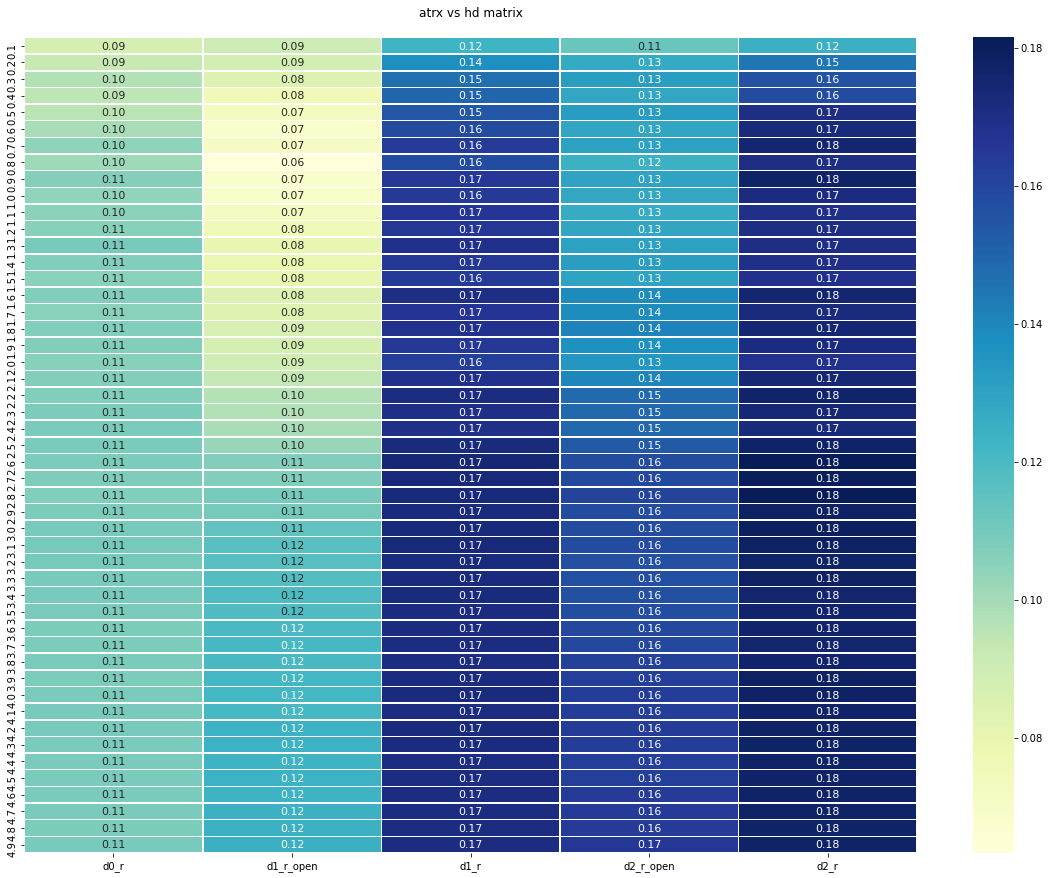


****************************** Gap Statistic ******************************

Number of data total: 3334
Number of data after dropping <0.5 ATR gap: 1299

Mean of Gap for differrent exch_location



--- General Gap Up Statistic ---

Count
Change from open      0.5-1 ATR    1-2 ATR    2-3 ATR    3-4 ATR    4-5 ATR    >5 ATR    All    prob.    prob. (>1 ATR)
------------------  -----------  ---------  ---------  ---------  ---------  --------  -----  -------  ----------------
Up                          181        102         48          8          7         5    351    0.519             0.289
Down                        195         79         22          9          4         2    311    0.46              0.197
No change                     6          3          2          1          0         2     14    0.021             0.014
All                         382        184         72         18         11         9    676    1                 1


Change from open         ('Close (ATRx)', 'mean')    ('High (ATRx)', 'mean')    ('Low (ATRx)', 'mean')    ('Close (ATRx)', 'median')    ('High (ATRx)', 'median')    ('Low (ATRx)', 'median')
---------------------  --------------------------  


****************************** Limit Order Analysis ******************************


        use market order for all LONG trades with absolute gap > 1.0:
        d0_expectancy: 0.24905
        d1_expectancy: 0.30929
        d0_total_r: 97.13145
        d1_total_r: 120.62210

        use market order for all SHORT trades with all absolute gap > 1.0:
        d0_expectancy: 0.09822
        d1_expectancy: 0.16944
        d0_total_r: 20.72342
        d1_total_r: 35.75282

        



****************************** Stop Loss Level Analysis ******************************


--- Side: long ---

Start Date: 2017-03-02
End Date: 2020-05-19


d0                                    \
                     stop loss at 0.1 stop loss at 0.5 stop loss at 1.0   
total_r                       127.068          110.431          124.981   
expectancy                      0.070            0.061            0.069   
total_trades                 1822.000         1822.000         1822.000   
hit_ratio                       0.167            0.436            0.504   
average_holding_days              NaN              NaN              NaN   
average_atrx_used               1.000            1.000            1.000   
stop_loss_ratio                 0.830            0.428            0.151   
averge_pos_per_day              5.859            5.859            5.859   

                                                                         
                     stop loss at 1.5 stop loss at 2.5 stop loss at 3.0  
total_r                       107.723          105.127          110.026  
expectancy                      0.059            0.058            0.060  
total_trades                 1822.000         1822.000         1822.000  
hit_ratio                       0.510            0.513            0.513  
average_holding_days              NaN              NaN              NaN  
average_atrx_used               1.000            1.000            1.000  
stop_loss_ratio                 0.063            0.011            0.004  
averge_pos_per_day              5.859            5.859            5.859

Setting (stop loss at 0.3) achived max total r: 133.08 R
Setting (stop loss at 0.3) achived max expectancy: 0.07304

--- Side: short ---

Start Date: 2017-05-02
End Date: 2020-05-19


d0                                    \
                     stop loss at 0.1 stop loss at 0.5 stop loss at 1.0   
total_r                        77.079          119.323          104.770   
expectancy                      0.085            0.131            0.115   
total_trades                  911.000          911.000          911.000   
hit_ratio                       0.200            0.512            0.557   
average_holding_days              NaN              NaN              NaN   
average_atrx_used               1.000            1.000            1.000   
stop_loss_ratio                 0.800            0.351            0.128   
averge_pos_per_day              3.910            3.910            3.910   

                                                                         
                     stop loss at 1.5 stop loss at 2.5 stop loss at 3.0  
total_r                       109.893          114.819          115.105  
expectancy                      0.121            0.126            0.126  
total_trades                  911.000          911.000          911.000  
hit_ratio                       0.568            0.569            0.569  
average_holding_days              NaN              NaN              NaN  
average_atrx_used               1.000            1.000            1.000  
stop_loss_ratio                 0.054            0.005            0.002  
averge_pos_per_day              3.910            3.910            3.910

Setting (stop loss at 0.5) achived max total r: 119.32 R
Setting (stop loss at 0.5) achived max expectancy: 0.13098




--- Different gap grps  ---




In [3]:
filters_dict = {
     # 'exch_region' : ['Europe',],
     # 'year' : [ 2020 ] ,
     # 'month' : [i for i in range(0,9)],
     # 'gics1' : ['Health Care'],
     
}

pnl = Risk_Management(data, filters_dict)
pnl._pnl_statistics(tabulate_display = True)
# pnl._rolling_atrx_calculation()
pnl._pnl_visulazation(skip_rolling = True, line_mode='lines')
pnl._atrx_vs_hd_matrix()
pnl._gap_statistics()
pnl._limit_order_performance_visualization()
# pnl._num_of_trades_analysis_and_visualization(data_with_score = data_sensit_table, socre_col = 'New Score')
pnl._stop_loss_level_analysis()